# Exploring Word Embeddings

Adapted from [the BERT for Humanists](https://melaniewalsh.github.io/BERT-for-Humanists/) Team

How can we measure the similarity of words in a collection of texts? For example, how similar are the words "nature" and "science" in a collection of 16th-20th century English language poems? Do 20th-century poets use the word "science" differently than 16th-century poets? Can we map all the different uses and meanings of the word "nature"?

The short answer is: yes! We can explore all of these questions with word embeddings! There are two types of embeddings: **static** or type-based where each word has a single vector or embedding, and **contextualized** or token-based where each word can have multiple vectors based on its context.

## In This Notebook
In this Colab notebook, we will specifically analyze a collection of poems scraped from [Public-Domain-Poetry.com](http://public-domain-poetry.com/) with the [GLoVe](https://nlp.stanford.edu/projects/glove/) and [DistilBert model](https://huggingface.co/transformers/model_doc/distilbert.html).

## **Import necessary Python libraries and modules**

In [1]:
# For data manipulation and analysis
import pandas as pd
pd.options.display.max_colwidth = 200
import numpy as np

Ok enough introduction! Let's get started.

To use the HuggingFace [`transformers` Python library](https://huggingface.co/transformers/installation.html), we first need to install it with `pip`.

In [2]:
!pip install gensim

In [3]:
!pip install transformers

In [4]:
# For GLoVe

from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

Gensim provides a convenient KeyedVectors class to work with word vectors. You'll need to download the pre-trained GloVe embeddings in advance. Download GloVe pre-trained word vectors from the GloVe website (https://nlp.stanford.edu/projects/glove/)

Here's an example using the Gensim library to load pre-trained GloVe embeddings:



In [5]:
glove_file = datapath('/content/glove.6B.50d.txt')
word2vec_glove_file = get_tmpfile("glove.6B.50d.word2vec.txt")
glove2word2vec(glove_file, word2vec_glove_file)

<ipython-input-5-dfae7b24fe45>:3: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec(glove_file, word2vec_glove_file)


(400000, 50)

In [6]:
glove_model = KeyedVectors.load_word2vec_format(word2vec_glove_file)

Uploading the model to google colab might take some time. In the meantime, while the model is being uploaded, feel free to check out the BERT embeddings.

Now, you have loaded the pre-trained GloVe word vectors using Gensim. You can use glove_model to perform various operations, such as getting the vector for a specific word or finding similar words.

In [7]:
# Get the vector for a specific word
vector_for_word = glove_model['example']

# Find similar words to a given word
similar_words = glove_model.most_similar('example', topn=5)

# Print the results
print("Vector for 'example':", vector_for_word)
print("Similar words to 'example':", similar_words)

Vector for 'example': [ 0.51564    0.56912   -0.19759    0.0080456  0.41697    0.59502
 -0.053312  -0.83222   -0.21715    0.31045    0.09352    0.35323
  0.28151   -0.35308    0.23496    0.04429    0.017109   0.0063749
 -0.01662   -0.69576    0.019819  -0.52746   -0.14011    0.21962
  0.13692   -1.2683    -0.89416   -0.1831     0.23343   -0.058254
  3.2481    -0.48794   -0.01207   -0.81645    0.21182   -0.17837
 -0.02874    0.099358  -0.14944    0.2601     0.18919    0.15022
  0.18278    0.50052   -0.025532   0.24671    0.10596    0.13612
  0.0090427  0.39962  ]
Similar words to 'example': [('instance', 0.9669908881187439), ('particular', 0.9291923642158508), ('such', 0.9044108390808105), ('similar', 0.9010181427001953), ('same', 0.9001578092575073)]


Similarly, we will import the DistilBertModel and DistilBertTokenizerFast from the Hugging Face `transformers` library. We will also import a handful of other Python libraries and modules.

In [8]:
# For BERT
from transformers import DistilBertTokenizerFast, DistilBertModel

# for dimensionality reduction and visualizing the embeddings
from sklearn.decomposition import PCA

# For interactive data visualization
import altair as alt

## **Load text dataset**

Our dataset contains around ~30 thousand poems scraped from  http://public-domain-poetry.com/. This website hosts a curated collection of poems that have fallen out of copyright, which makes them easier for us to share on the web.
You can find the data in our [GitHub repository](https://github.com/melaniewalsh/BERT-4-Humanists/blob/main/data/public-domain-poetry.csv).

We don't have granular date information about when each poem was published, but we do know the birth dates of most of our authors, which we've used to loosely categorize the poems by time period. The poems in our data range from the Middle Ages to the 20th Century, but most come from the 19th Century. The data features both well-known authors — William Wordsworth, Emily Elizabeth Dickinson, Paul Laurence Dunbar, Walt Whitman, Shakespeare — as well as less well-known authors.

Below we will use the Python library `pandas` to read in our CSV file of poems. It is convenient (especially for Colab notebooks) that `pandas` allows you to read in files directly from the web.

In [9]:
url = "https://raw.githubusercontent.com/melaniewalsh/BERT-4-Humanists/main/data/public-domain-poetry.csv"

poetry_df = pd.read_csv(url, encoding='utf-8')
# Show 5 random rows
poetry_df.sample(5)

,author,title,text,lifespan,birth_year,death_year,link,period
25017,Thomas Moore,Animal Magnetism,"Tho' famed was Mesmer, in his day,\r\nNor less so, in ours, is Dupotet,\r\nTo say nothing of all the wonders done\r\nBy that wizard, Dr. Elliotson,\r\nWhen, standing as if the gods to invoke, he\r...",28 May 1779-25 February 1852,1779.0,1852.0,http://public-domain-poetry.com/thomas-moore/animal-magnetism-27304,19th Century
12101,John Dryden,"Prologue To ""Sophonisba,""","ACTED AT OXFORD, 1680.\n\r\nWRITTEN BY NATHAN LEE.\n\n\r\nThespis,[1] the first professor of our art,\r\nAt country wakes sung ballads from a cart.\r\nTo prove this true, if Latin be no trespass,\...",( 9 August 1631-1 May 1700 ),1631.0,1700.0,http://public-domain-poetry.com/john-dryden/prologue-to-sophonisba-14696,16th-17th Centuries (Early Modern)
7369,Francesco Petrarca (Petrarch),Sonnet CCXI,"Qual paura ho, quando mi torna a mente.\n\r\nMELANCHOLY RECOLLECTIONS AND PRESAGES.\n\n\r\nO Laura! when my tortured mind\r\nThe sad remembrance bears\r\nOf that ill-omen'd day,\r\nWhen, victim to...","July 20, 1304-July 19, 1374",1304.0,1374.0,http://public-domain-poetry.com/francesco-petrarca/sonnet-ccxi-28642,12th-15th Centuries (Middle English)
26640,Walt Whitman,The Sobbing Of The Bells,"The sobbing of the bells, the sudden death-news everywhere,\r\nThe slumberers rouse, the rapport of the People,\r\n(Full well they know that message in the darkness,\r\nFull well return, respond w...","May 31, 1819-March 26, 1892",1819.0,1892.0,http://public-domain-poetry.com/walt-whitman/sobbing-of-the-bells-1008,19th Century
27484,Walter R. Cassels,A Night Scene,"The lights have faded from the little casement,\r\nAs though her closing eyes had brought on night;\r\nAnd now she dreams--Ah! dreams supremely bright,\r\nWhile silence reigns around from roof to ...",4 September 1826 - 10 June 1907,1826.0,1907.0,http://public-domain-poetry.com/walter-r-cassels/night-scene-11004,19th Century


In [10]:
len(poetry_df)

31080

Let's check to see which authors show up the most in this dataset to get a sense of its contours:

In [11]:
poetry_df['author'].value_counts()[:20]

Robert Herrick                   1464
Madison Julius Cawein            1345
William Wordsworth                963
Thomas Moore                      853
Thomas Hardy                      655
Rudyard Kipling                   638
Robert Burns                      499
John Greenleaf Whittier           481
Algernon Charles Swinburne        461
Emily Elizabeth Dickinson         447
Paul Laurence Dunbar              417
John Clare                        382
William Butler Yeats              378
Francesco Petrarca (Petrarch)     375
Paul Cameron Brown                341
Walt Whitman                      338
Edgar Lee Masters                 331
Percy Bysshe Shelley              330
Walter De La Mare                 329
Oliver Wendell Holmes             329
Name: author, dtype: int64

Let's check to see what time periods show up the most in this dataset to get a sense of its contours:

<Axes: >

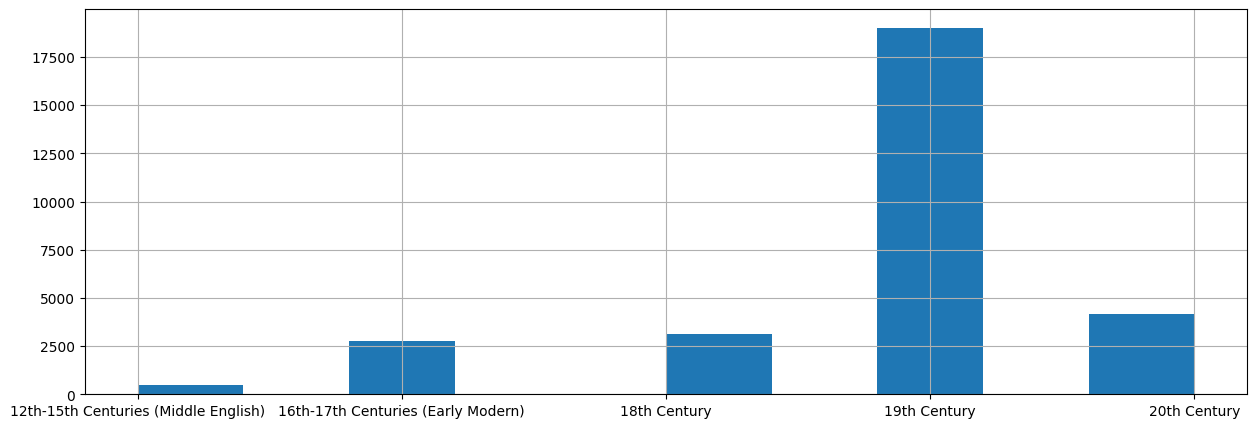

In [12]:
# Sort values, then create a histogram, and define the size of the figure
poetry_df['period'].sort_values().hist(figsize=(15, 5))

## **Sample text dataset**

Though we wish we could analyze all the poems in this data, Colab tends to crash if we try to use more than 4-5,000 poems —  even with DistilBert, the smaller version of BERT. This is an important limitation to keep in mind. If you'd like to use more text data, you might consider upgrading to a paid version of Colab (with more memory or GPUs) or using a compute cluster.

To reduce the number of poems, we will take a random sample of 1,000 poems from four different time periods: the 20th Century, 19th Century, 18th Century, and the Early Modern period.

In [13]:
# Filter the DataFrame for only a given time period, then randomly sample 1000 rows
nineteenth_sample = poetry_df[poetry_df['period'] == '19th Century'].sample(1000)
twentieth_sample = poetry_df[poetry_df['period'] == '20th Century'].sample(1000)
eighteenth_sample = poetry_df[poetry_df['period'] == '18th Century'].sample(1000)
sixteenth_sample = poetry_df[poetry_df['period'] == '16th-17th Centuries (Early Modern)'].sample(1000)

In [14]:
# Merge these random samples into a new DataFrame
poetry_df = pd.concat([sixteenth_sample, eighteenth_sample, twentieth_sample, nineteenth_sample])

In [15]:
poetry_df['period'].value_counts()

16th-17th Centuries (Early Modern)    1000
18th Century                          1000
20th Century                          1000
19th Century                          1000
Name: period, dtype: int64

Finally, let's make a list of poems from our Pandas DataFrame.

In [16]:
poetry_texts = poetry_df['text'].tolist()

Let's examine a poem in our dataset:

In [17]:
len(poetry_texts)

4000

In [18]:
print(poetry_texts[0])

My God! look on me with Thine eye
Of pity, not of scrutiny;
For if Thou dost, Thou then shalt see
Nothing but loathsome sores in me.
O then, for mercy's sake, behold
These my eruptions manifold,
And heal me with Thy look or touch;
But if Thou wilt not deign so much,
Because I'm odious in Thy sight,
Speak but the word, and cure me quite.


## **Encode/tokenize text data for GLoVe and BERT**

In [19]:
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')

# Load GloVe model into Gensim
glove_model = KeyedVectors.load_word2vec_format(word2vec_glove_file)

def embed_sentence(sentence, model):
    # Tokenize the sentence into words
    words = word_tokenize(sentence.lower())

    # Filter out words that are not in the vocabulary
    words_in_vocab = [word for word in words if word in model]

    if not words_in_vocab:
        # If no words are in the vocabulary, return None
        return None

    # Calculate the mean of the word vectors for the words in the sentence
    sentence_vector = np.mean([model[word] for word in words_in_vocab], axis=0)

    return sentence_vector

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [20]:
sentences = poetry_texts

# Embed each sentence
for sentence in sentences:
    vector = embed_sentence(sentence, glove_model)

# If you want to save the sentence vectors for later use:
np.save("sentence_vectors.npy", np.array([embed_sentence(sentence, glove_model) for sentence in sentences]))

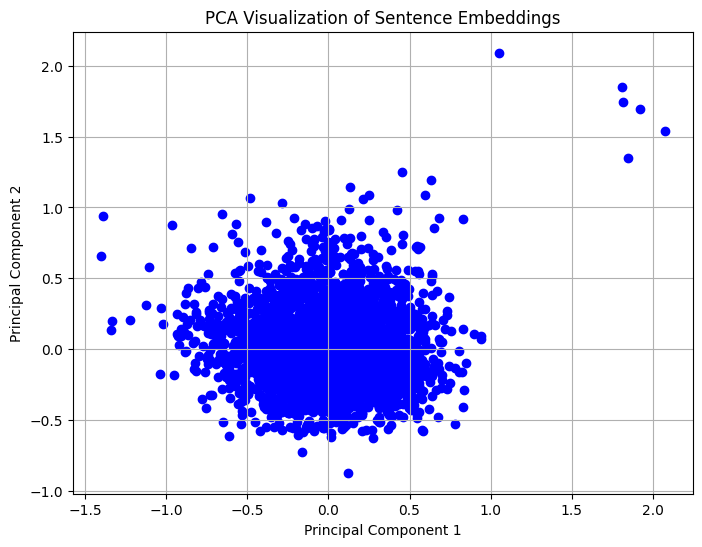

In [21]:
import matplotlib.pyplot as plt

# Load sentence vectors (replace with your own vectors or use the saved vectors)
sentence_vectors = np.load("sentence_vectors.npy")

# Perform PCA for dimensionality reduction
pca = PCA(n_components=2)
reduced_vectors = pca.fit_transform(sentence_vectors)

# Plot the reduced vectors
plt.figure(figsize=(8, 6))
plt.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1], c='blue', marker='o')

# # Annotate points with corresponding sentences
# for i, txt in enumerate(sentences):
#     plt.annotate(txt, (reduced_vectors[i, 0], reduced_vectors[i, 1]))

plt.title('PCA Visualization of Sentence Embeddings')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)

In [22]:
def display_pca_scatterplot(model, words=None, sample=0):
    if words is None:
        if sample > 0:
            words = np.random.choice(list(model.key_to_index.keys()), sample)
        else:
            words = [word for word in model.key_to_index]

    word_vectors = np.array([model[word] for word in words])

    twodim = PCA().fit_transform(word_vectors)[:, :2]

    plt.figure(figsize=(6, 6))
    plt.scatter(twodim[:, 0], twodim[:, 1], edgecolors='k', c='r')
    for word, (x, y) in zip(words, twodim):
        plt.text(x + 0.05, y + 0.05, word)

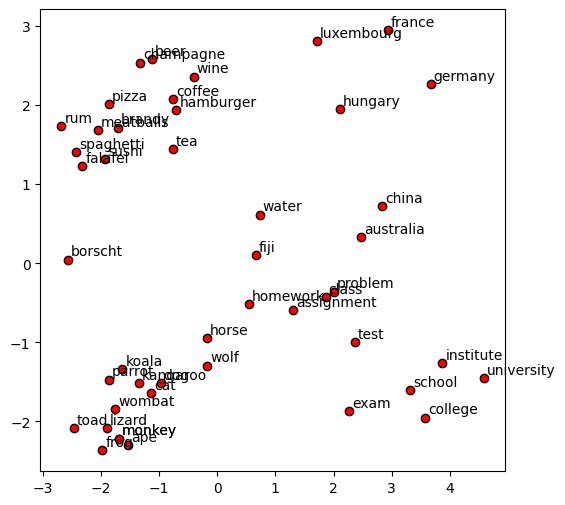

In [23]:
display_pca_scatterplot(glove_model,
                        ['coffee', 'tea', 'beer', 'wine', 'brandy', 'rum', 'champagne', 'water',
                         'spaghetti', 'borscht', 'hamburger', 'pizza', 'falafel', 'sushi', 'meatballs',
                         'dog', 'horse', 'cat', 'monkey', 'parrot', 'koala', 'lizard',
                         'frog', 'toad', 'monkey', 'ape', 'kangaroo', 'wombat', 'wolf',
                         'france', 'germany', 'hungary', 'luxembourg', 'australia', 'fiji', 'china',
                         'homework', 'assignment', 'problem', 'exam', 'test', 'class',
                         'school', 'college', 'university', 'institute'])

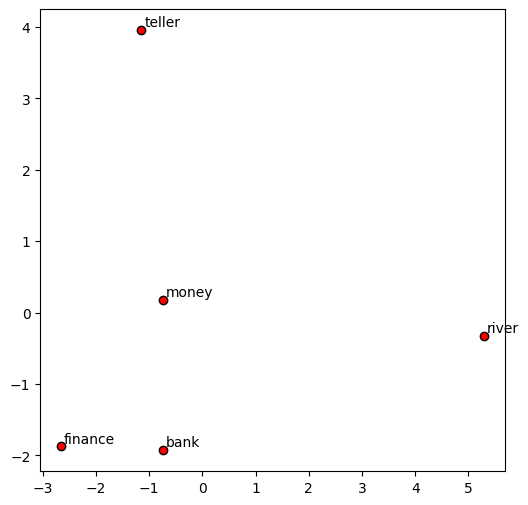

In [24]:
display_pca_scatterplot(glove_model,
                        ['bank', 'money', 'finance', 'river', 'teller'])

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 26157 (\N{CJK UNIFIED IDEOGRAPH-662D}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 32681 (\N{CJK UNIFIED IDEOGRAPH-7FA9}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 26157 (\N{CJK UNIFIED IDEOGRAPH-662D}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 32681 (\N{CJK UNIFIED IDEOGRAPH-7FA9}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


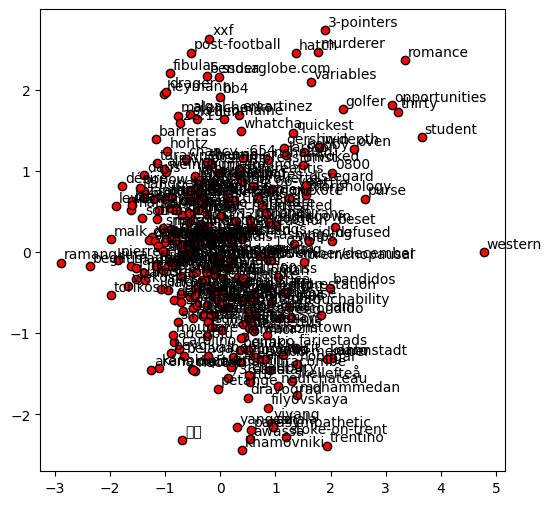

In [25]:
# now on a random sample of words
display_pca_scatterplot(glove_model, sample = 300)

## Now, let's try with contextualized embeddings

For the contxtualized embeddings from BERT, we need to transform our poems into a format that BERT (via Huggingface) will understand. This is called *encoding* or *tokenizing* the data.

We will tokenize the poems with the `tokenizer()` from HuggingFace's `DistilBertTokenizerFast`. Here's what the `tokenizer()` will do:

1. Truncate the texts if they're more than 512 tokens or pad them if they're fewer than 512 tokens. If a word is not in BERT's vocabulary, it will be broken up into smaller "word pieces," demarcated by a `##`.

2. Add in special tokens to help BERT:
    - [CLS] — Start token of every document
    - [SEP] — Separator between each sentence
    - [PAD] — Padding at the end of the document as many times as necessary, up to 512 tokens
    - &#35;&#35; — Start of a "word piece"
    
Here we will load `DistilBertTokenizerFast` from HuggingFace library, which will help us transform and encode the texts so they can be used with BERT.

In [26]:
from transformers import DistilBertTokenizerFast

In [27]:
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

The `tokenizer()` will break word tokens into word pieces, truncate to 512 tokens, and add padding and special BERT tokens.

In [28]:
tokenized_poems = tokenizer(poetry_texts, truncation=True, padding=True, return_tensors="pt")

Let's examine the first tokenized poem. We can see that the special BERT tokens have been inserted where necessary.

In [29]:
' '.join(tokenized_poems[0].tokens)

"[CLS] my god ! look on me with thin ##e eye of pity , not of scrutiny ; for if thou dos ##t , thou then sha ##lt see nothing but lo ##ath ##some sore ##s in me . o then , for mercy ' s sake , behold these my eruptions manifold , and heal me with thy look or touch ; but if thou wil ##t not dei ##gn so much , because i ' m odi ##ous in thy sight , speak but the word , and cure me quite . [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD

<br><br>

## **Load pre-trained BERT model**

Here we will load a pre-trained BERT model. To speed things up we will use a GPU, but using GPU involves a few extra steps.
The command `.to("cuda")` moves data from regular memory to the GPU's memory.




In [30]:
from transformers import DistilBertModel

In [31]:
model = DistilBertModel.from_pretrained('distilbert-base-uncased').to("cuda")

## **Get BERT word embeddings for each document in a collection**

To get word embeddings for all the words in our collection, we will use a `for` loop.

For each poem in our list `poetry_texts`, we will tokenize the poem, and we will extract the vocabulary word ID for each word/token in the poem (to use for later reference). Then we will run the tokenized poem through the BERT model and extract the vectors for each word/token in the poem.

We thus create two big lists for all the poems in our collection — `doc_word_ids` and `doc_word_vectors`.

In [32]:
# List of vocabulary word IDs for all the words in each document (aka each poem)
doc_word_ids = []
# List of word vectors for all the words in each document (aka each poem)
doc_word_vectors = []

# Below we will slice our poem to ignore the first (0th) and last (-1) special BERT tokens
start_of_words = 1
end_of_words = -1

# Below we will index the 0th or first document, which will be the only document, since we're analzying one poem at a time
first_document = 0

for i, poem in enumerate(poetry_texts):

    # Here we tokenize each poem with the DistilBERT Tokenizer
    inputs = tokenizer(poem, return_tensors="pt", truncation=True, padding=True)

    # Here we extract the vocabulary word ids for all the words in the poem (the first or 0th document, since we only have one document)
    # We ignore the first and last special BERT tokens
    # We also convert from a Pytorch tensor to a numpy array
    doc_word_ids.append(inputs.input_ids[first_document].numpy()[start_of_words:end_of_words])

    # Here we send the tokenized poems to the GPU
    # The model is already on the GPU, but this poem isn't, so we send it to the GPU
    inputs.to("cuda")
    # Here we run the tokenized poem through the DistilBERT model
    outputs = model(**inputs)

    # We take every element from the first or 0th document, from the 2nd to the 2nd to last position
    # Grabbing the last layer is one way of getting token vectors. There are different ways to get vectors with different pros and cons
    doc_word_vectors.append(outputs.last_hidden_state[first_document,start_of_words:end_of_words,:].detach().cpu().numpy())


Confirm that we have the same number of documents for both the tokens and the vectors:

In [33]:
len(doc_word_ids), len(doc_word_vectors)

(4000, 4000)

In [34]:
doc_word_ids[0], doc_word_vectors[0]

(array([ 2026,  2643,   999,  2298,  2006,  2033,  2007,  4857,  2063,
         3239,  1997, 12063,  1010,  2025,  1997, 17423,  1025,  2005,
         2065, 15223,  9998,  2102,  1010, 15223,  2059, 21146,  7096,
         2156,  2498,  2021,  8840,  8988, 14045, 14699,  2015,  1999,
         2033,  1012,  1051,  2059,  1010,  2005,  8673,  1005,  1055,
         8739,  1010, 27541,  2122,  2026, 28448, 19726,  1010,  1998,
        11005,  2033,  2007, 15177,  2298,  2030,  3543,  1025,  2021,
         2065, 15223, 19863,  2102,  2025, 14866, 16206,  2061,  2172,
         1010,  2138,  1045,  1005,  1049, 21045,  3560,  1999, 15177,
         4356,  1010,  3713,  2021,  1996,  2773,  1010,  1998,  9526,
         2033,  3243,  1012]),
 array([[ 0.37710997,  0.9609308 ,  0.20562027, ..., -0.04241206,
          0.1055713 ,  0.17714587],
        [ 0.02137923,  0.60820985,  0.22406358, ...,  0.08903595,
         -0.03084533,  0.27970582],
        [-0.07764289,  0.5540802 , -0.08294504, ...,  0

## **Concatenate all word IDs/vectors for all documents**

Each element of these lists contains all the tokens/vectors for one document. But we want to concatenate them into two giant collections.

In [35]:
all_word_ids = np.concatenate(doc_word_ids)
all_word_vectors = np.concatenate(doc_word_vectors, axis=0)

We want to make comparisons between vectors quickly. One common option is *cosine similarity*, which measures the angle between vectors but ignores their length. We can speed this computation up by setting all the poem vectors to have length 1.0.

In [36]:
# Calculating the length of each vector (Pythagorean theorem)
row_norms = np.sqrt(np.sum(all_word_vectors ** 2, axis=1))
# Dividing every vector by its length
all_word_vectors /= row_norms[:,np.newaxis]

## **Find all word positions in a collection**

We can use the array `all_word_ids` to find all the places, or *positions*, in the collection where a word appears.

We can find a word's vocab ID in BERT with `tokenizer.vocab` and then check to see where/how many times this ID occurs in `all_word_ids`.

In [37]:
def get_word_positions(words):

  """This function accepts a list of words, rather than a single word"""

  # Get word/vocabulary ID from BERT for each word
  word_ids = [tokenizer.vocab[word] for word in words]

  # Find all the positions where the words occur in the collection
  word_positions = np.where(np.isin(all_word_ids, word_ids))[0]

  return word_positions

Here we'll check to see all the places where the word "bank" appears in the collection.

In [38]:
get_word_positions(["bank"])

array([ 16904, 105996, 115486, 145431, 203554, 207050, 218915, 247026,
       256020, 267323, 279863, 316470, 326261, 356880, 367311, 383759,
       402838, 422435, 453441, 465996, 465999, 494285, 520801, 533389,
       533679, 575134, 581520, 605351, 615877, 638527, 672761, 684794,
       690817, 693152, 708399, 763685, 764189, 782252, 797661, 804354,
       829016, 848922, 880029, 880100, 903672, 921468, 937740, 965213])

In [39]:
word_positions = get_word_positions(["bank"])

## **Find word from word position**

Nice! Now we know all the positions where the word "bank" appears in the collection. But it would be more helpful to know the actual words that appear in context around it. To find these context words, we have to convert position IDs back into words.

In [40]:
# Here we create an array so that we can go backwards from numeric token IDs to words
word_lookup = np.empty(tokenizer.vocab_size, dtype="O")

for word, index in tokenizer.vocab.items():
    word_lookup[index] = word

Now we can use `word_lookup` to find a word based on its position in the collection.

In [41]:
word_positions = get_word_positions(["bank"])

for word_position in word_positions:
  print(word_position, word_lookup[all_word_ids[word_position]])

16904 bank
105996 bank
115486 bank
145431 bank
203554 bank
207050 bank
218915 bank
247026 bank
256020 bank
267323 bank
279863 bank
316470 bank
326261 bank
356880 bank
367311 bank
383759 bank
402838 bank
422435 bank
453441 bank
465996 bank
465999 bank
494285 bank
520801 bank
533389 bank
533679 bank
575134 bank
581520 bank
605351 bank
615877 bank
638527 bank
672761 bank
684794 bank
690817 bank
693152 bank
708399 bank
763685 bank
764189 bank
782252 bank
797661 bank
804354 bank
829016 bank
848922 bank
880029 bank
880100 bank
903672 bank
921468 bank
937740 bank
965213 bank


We can also look for the 3 words that come before "bank" and the 3 words that come after it.

In [42]:
word_positions = get_word_positions(["bank"])

for word_position in word_positions:

  # Slice 3 words before "bank"
  start_pos = word_position - 3
  # Slice 3 words after "bank"
  end_pos = word_position + 4

  context_words = word_lookup[all_word_ids[start_pos:end_pos]]
  # Join the words together
  context_words = ' '.join(context_words)
  print(word_position, context_words)

16904 vp ##pon a bank with roses set
105996 upon a green bank yielding room for
115486 red ##eem a bank of moss ,
145431 ##tty * * bank , the which
203554 pri ##m ##rose bank , her throne
207050 , on some bank beside a river
218915 river ' s bank , in fable
247026 cows ##lip - bank and shady willow
256020 er yo ##n bank and o '
267323 ##no ' s bank , and on
279863 down upon a bank , where love
316470 lily by the bank , the pri
326261 from the snowy bank the foot ##marks
356880 thorn ##ie - bank , when they
367311 hedge , and bank , and stil
383759 ##ied a western bank ' s still
402838 sees but the bank that from thee
422435 on the green bank of clear al
453441 , come ##ly bank and may ,
465996 , from , bank to low bank
465999 bank to low bank of the river
494285 on the river bank where i came
520801 . . the bank default ##er lee
533389 shrine is a bank of so ##d
533679 shrine is a bank of so ##d
575134 ho ##llie ##d bank , the winter
581520 on the other bank crouch ##es april
605351 up

Let's make some functions that will help us get the context words around a certain word position for whatever size window (certain number of words before and after) that we want.

The first function `get_context()` will simply return the tokens without cleaning them, and the second function `get_context_clean()` will return the tokens in a more readable fashion.

In [43]:
def get_context(word_id, window_size=10):

  """Simply get the tokens that occur before and after word position"""

  start_pos = max(0, word_id - window_size) # The token where we will start the context view
  end_pos = min(word_id + window_size + 1, len(all_word_ids)) # The token where we will end the context view

  # Make a list called tokens and use word_lookup to get the words for given token IDs from starting position up to the keyword
  tokens = [word_lookup[word] for word in all_word_ids[start_pos:end_pos] ]

  context_words = " ".join(tokens)

  return context_words

In [44]:
import re

def get_context_clean(word_id, window_size=10):

  """Get the tokens that occur before and after word position AND make them more readable"""

  keyword = word_lookup[all_word_ids[word_id]]
  start_pos = max(0, word_id - window_size) # The token where we will start the context view
  end_pos = min(word_id + window_size + 1, len(all_word_ids)) # The token where we will end the context view

  # Make a list called tokens and use word_lookup to get the words for given token IDs from starting position up to the keyword
  tokens = [word_lookup[word] for word in all_word_ids[start_pos:end_pos] ]

  # Make wordpieces slightly more readable
  # This is probably not the most efficient way to clean and correct for weird spacing
  context_words = " ".join(tokens)
  context_words = re.sub(r'\s+([##])', r'\1', context_words)
  context_words = re.sub(r'##', r'', context_words)
  context_words = re.sub('\s+\'s', '\'s', context_words)
  context_words = re.sub('\s+\'d', '\'d', context_words)
  context_words = re.sub('\s\'er', '\'er', context_words)
  context_words = re.sub(r'\s+([-,:?.!;])', r'\1', context_words)
  context_words = re.sub(r'([-\'"])\s+', r'\1', context_words)
  context_words = re.sub('\s+\'s', '\'s', context_words)
  context_words = re.sub('\s+\'d', '\'d', context_words)

  # Bold the keyword by putting asterisks around it
  if keyword in context_words:
    context_words = re.sub(f"\\b{keyword}\\b", f"**{keyword}**", context_words)
    context_words = re.sub(f"\\b({keyword}[esdtrlying]+)\\b", fr"**\1**", context_words)

  return context_words

To visualize the search keyword even more easily, we're going to import a couple of Python modules that will allow us to output text with bolded words and other styling. Here we will make a function `print_md()` that will allow us to print with Markdown styling.

In [45]:
from IPython.display import Markdown, display

def print_md(string):
    display(Markdown(string))

In [46]:
word_positions = get_word_positions(["bank"])

for word_position in word_positions:

  print_md(f"<br> {word_position}:  {get_context_clean(word_position)} <br>")

<br> 16904:  within a manger lodged thy lord vppon a **bank** with roses set about, where pretty turtles ioyn <br>

<br> 105996:  now as an angler melancholy standing upon a green **bank** yielding room for landing, a wriggling yellow <br>

<br> 115486:  and many a cross-track they redeem a **bank** of moss, spongy and swelling, and <br>

<br> 145431:  silver streaming themmes; whose rutty * * **bank**, the which his river hemmes, was pay <br>

<br> 203554:  under her dominion placed. upon a primrose **bank**, her throne of quietness, she sits alone <br>

<br> 207050:  , and in our mossy valleys, on some **bank** beside a river clear, throw thy silk draperies <br>

<br> 218915:  [ 1 ] thus, on the river's **bank**, in fabled lore, the rustic stands; <br>

<br> 247026:  , in this sweet book, the cowslip-**bank** and shady willow-tree; and the fresh mead <br>

<br> 256020:  dearie. ii. o 'er yon **bank** and o 'er yon brae, o <br>

<br> 267323:  's golden store, on arno's **bank**, and on that bloomy shore, warbling <br>

<br> 279863:  to detain. i laid me down upon a **bank**, where love lay sleeping; i heard among the <br>

<br> 316470:  t. iii. now blooms the lily by the **bank**, the primrose down the brae; <br>

<br> 326261:  they came. they follow'd from the snowy **bank** the footmarks, one by one, into the <br>

<br> 356880:  . a 'the lads o 'thornie-**bank**, when they gae to the shore o ' <br>

<br> 367311:  waves efface pathway, and hedge, and **bank**, and stile!-i find but one <br>

<br> 383759:  . distant a little mile he spied a western **bank**'s still sunny side, and right toward the <br>

<br> 402838:  deride that shortsighted one sees but the **bank** that from thee is flying, not the one which <br>

<br> 422435:  , 'mid the circling wood, on the green **bank** of clear alb [ = u ] nea <br>

<br> 453441:  . there's barbara cowie, comely **bank** and may, christened, at home, in <br>

<br> 465996:  's cry, wild or grave, from, **bank** to low **bank** of the river rings; but the <br>

<br> 465999:  , wild or grave, from, **bank** to low **bank** of the river rings; but the uncertain river though <br>

<br> 494285:  nty hand. i still walk slowly on the river **bank** where i came singing, and where i saw your <br>

<br> 520801:  the watchman climbs the stair... the **bank** defaulter leers at a chaos of figures, <br>

<br> 533389:  a buttercup bright, and our shrine is a **bank** of sod, but still we share st. <br>

<br> 533679:  a buttercup bright, and our shrine is a **bank** of sod, but still we share st. <br>

<br> 575134:  mists that cloak hanger and hollied **bank**, the winter world awoke to hear the feeble <br>

<br> 581520:  across a huge gulf... on the other **bank** crouches april with her hair as smooth and straight <br>

<br> 605351:  her ankles gleam; she scrambles up the grassy **bank** and on, though courage and quick breath are nearly <br>

<br> 615877:  just get up and take another cuff; you may **bank** on it that there is no philosophy like bluff and <br>

<br> 638527:  ? come, come away to the river's **bank**, come in the early morning; come when the <br>

<br> 672761:  for the law; the stagnation of a **bank** we couldn 't stand; for our riot blood <br>

<br> 684794:  delions like to suns will bloom, aside some **bank** or hillock creeping low;--though each <br>

<br> 690817:  'r and the primrose pale, on **bank** or copse, and orchis rare, <br>

<br> 693152:  mouth, to take from scorn the hook with **bank**-notes baited! its self-compl <br>

<br> 708399:  helping to land old thomas rhodes for wrecking the **bank**, and the judge was a friend of rhodes and <br>

<br> 763685:  as with wool here and there; with now a **bank** hot of color; and the cool dark-blue <br>

<br> 764189:  e, she sat her downe upon a green **bank**, and her true love came riding bye. she <br>

<br> 782252:  ... stranger! awhile upon this mossy **bank** recline thee. if the sun rides high, <br>

<br> 797661:  in its web of fog, or where the grand **bank** shallows with the wrecks of sunken fishers <br>

<br> 804354:  better than **banking**, trade or leases, take a **bank** note and fold it up, and then you will <br>

<br> 829016:  s city, by a rotten tree, or woodland **bank**! in ignorance we muse: pausing, annoy <br>

<br> 848922:  . and one, a green thyme-honoured **bank**, where flowers are growing wild and rank, like <br>

<br> 880029:  her nest in a hole of the high clay-**bank** there near miller's ford. but no sooner <br>

<br> 880100:  and rearing his head, fell backward down the **bank** into spoon river and was drowned. scarcely an hour <br>

<br> 903672:  s mounds are strown; cave in the **bank** where the sly stream steals; aloe that stab <br>

<br> 921468:  sweep past, o 'er the low clouds that **bank** the sky, and barrier day off solemnly. above <br>

<br> 937740:  head, to vernal airs the mossy **bank** its sheeny primrose spangles spread, <br>

<br> 965213:  savored much of heaven. close by the **bank**, in shady nooks, the waxen <br>

Here we make a list of all the context views for our keyword.

In [47]:
word_positions = get_word_positions(["bank"])

keyword_contexts = []
keyword_contexts_tokens = []

for position in word_positions:

  keyword_contexts.append(get_context_clean(position))
  keyword_contexts_tokens.append(get_context(position))

## **Get word vectors and reduce them with PCA**

Finally, we don't just want to *read* all the instances of "bank" in the collection, we want to *measure* the similarity of all the instances of "bank."

To measure similarity between all the instances of "bank," we will take the vectors for each instance and then use PCA to reduce each 768-dimensionsal vector to the 2 dimensions that capture the most variation.

In [48]:
word_positions = get_word_positions(["bank"])

pca = PCA(n_components=2)

pca.fit(all_word_vectors[word_positions,:].T)

PCA(n_components=2)

Then, for convenience, we will put these PCA results into a Pandas DataFrame, which will use to generate an interactive plot.

In [49]:
df = pd.DataFrame({"x": pca.components_[0,:], "y": pca.components_[1,:],
                   "context": keyword_contexts, "tokens": keyword_contexts_tokens})
df.head()

,x,y,context,tokens
0,-0.152710,-0.079287,"within a manger lodged thy lord vppon a **bank** with roses set about, where pretty turtles ioyn","within a man ##ger lodged thy lord vp ##pon a bank with roses set about , where pretty turtles io ##yn"
1,-0.150900,0.135765,"now as an angler melancholy standing upon a green **bank** yielding room for landing, a wriggling yellow","now as an angle ##r melancholy standing upon a green bank yielding room for landing , a wr ##ig ##gling yellow"
2,-0.137619,-0.133764,"and many a cross-track they redeem a **bank** of moss, spongy and swelling, and","and many a cross - track they red ##eem a bank of moss , sp ##ong ##y and swelling , and"
3,-0.145368,-0.070042,"silver streaming themmes; whose rutty * * **bank**, the which his river hemmes, was pay","silver streaming them ##mes ; whose ru ##tty * * bank , the which his river hem ##mes , was pay"
4,-0.147979,-0.065450,"under her dominion placed. upon a primrose **bank**, her throne of quietness, she sits alone","under her dominion placed . upon a pri ##m ##rose bank , her throne of quiet ##ness , she sits alone"


## **Match context with original text and metadata**

It's helpful (and fun!) to know where each instance of a word actually comes from — which poem, which poet, which time period, which Public-Domain-Poetry.com web page. The easiest method we've found for matching a bit of context with its original poem and metdata is to 1) add a tokenized version of each poem to our original Pandas Dataframe 2) check to see if the context shows up in a poem 3) and if so, grab the original poem and metadata.

In [50]:
# Tokenize all the poems
tokenized_poems = tokenizer(poetry_texts, truncation=True, padding=True, return_tensors="pt")

# Get a list of all the tokens for each poem
all_tokenized_poems = []
for i in range(len(tokenized_poems['input_ids'])):
  all_tokenized_poems.append(' '.join(tokenized_poems[i].tokens))

# Add them to the original DataFrame
poetry_df['tokens'] = all_tokenized_poems

In [51]:
poetry_df.head(2)

,author,title,text,lifespan,birth_year,death_year,link,period,tokens
21176,Robert Herrick,His Ejaculation To God,"My God! look on me with Thine eye\r\nOf pity, not of scrutiny;\r\nFor if Thou dost, Thou then shalt see\r\nNothing but loathsome sores in me.\r\nO then, for mercy's sake, behold\r\nThese my erupti...","Baptized - August 24, 1591- October 1674",1591.0,1674.0,http://public-domain-poetry.com/robert-herrick/his-ejaculation-to-god-19691,16th-17th Centuries (Early Modern),"[CLS] my god ! look on me with thin ##e eye of pity , not of scrutiny ; for if thou dos ##t , thou then sha ##lt see nothing but lo ##ath ##some sore ##s in me . o then , for mercy ' s sake , beho..."
20585,Robert Herrick,Upon Lulls,Lulls swears he is all heart; but you'll suppose\r\nBy his proboscis that he is all nose.,"Baptized - August 24, 1591- October 1674",1591.0,1674.0,http://public-domain-poetry.com/robert-herrick/upon-lulls-19455,16th-17th Centuries (Early Modern),[CLS] lu ##lls swear ##s he is all heart ; but you ' ll suppose by his pro ##bos ##cis that he is all nose . [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PA...


In [52]:
def find_original_poem(rows):

  """This function checks to see whether the context tokens show up in the original poem,
  and if so, returns metadata about the title, author, period, and URL for that poem"""

  text = rows['tokens'].replace('**', '')
  text = text[55:70]

  if poetry_df['tokens'].str.contains(text, regex=False).any() == True :
    row = poetry_df[poetry_df['tokens'].str.contains(text, regex=False)].values[0]
    title, author, period, link = row[0], row[1], row[7], row[6]
    return author, title, period, link
  else:
    return None, None, None, None

In [53]:
df[['title', 'author', 'period', 'link']] = df.apply(find_original_poem, axis='columns', result_type='expand')

In [54]:
df

,x,y,context,tokens,title,author,period,link
0,-0.152710,-0.079287,"within a manger lodged thy lord vppon a **bank** with roses set about, where pretty turtles ioyn","within a man ##ger lodged thy lord vp ##pon a bank with roses set about , where pretty turtles io ##yn",From Eclogue ij,Michael Drayton,16th-17th Centuries (Early Modern),http://public-domain-poetry.com/michael-drayton/from-eclogue-ij-14586
1,-0.150900,0.135765,"now as an angler melancholy standing upon a green **bank** yielding room for landing, a wriggling yellow","now as an angle ##r melancholy standing upon a green bank yielding room for landing , a wr ##ig ##gling yellow",An Angler,William Browne,16th-17th Centuries (Early Modern),http://public-domain-poetry.com/william-browne/an-angler-36470
2,-0.137619,-0.133764,"and many a cross-track they redeem a **bank** of moss, spongy and swelling, and","and many a cross - track they red ##eem a bank of moss , sp ##ong ##y and swelling , and",Oberon's Palace,Robert Herrick,16th-17th Centuries (Early Modern),http://public-domain-poetry.com/robert-herrick/oberons-palace-18864
3,-0.145368,-0.070042,"silver streaming themmes; whose rutty * * **bank**, the which his river hemmes, was pay","silver streaming them ##mes ; whose ru ##tty * * bank , the which his river hem ##mes , was pay","Prothalamion: Or, A Spousall Verse",Edmund Spenser,16th-17th Centuries (Early Modern),http://public-domain-poetry.com/edmund-spenser/prothalamion-or-a-spousall-verse-32239
4,-0.147979,-0.065450,"under her dominion placed. upon a primrose **bank**, her throne of quietness, she sits alone","under her dominion placed . upon a pri ##m ##rose bank , her throne of quiet ##ness , she sits alone","The White Doe Of Rylstone, Or, The Fate Of The Nortons - Canto Seventh",William Wordsworth,18th Century,http://public-domain-poetry.com/william-wordsworth/white-doe-of-rylstone-or-the-fate-of-the-nortons-canto-seventh-4078
5,-0.148591,0.212654,", and in our mossy valleys, on some **bank** beside a river clear, throw thy silk draperies",", and in our moss ##y valleys , on some bank beside a river clear , throw thy silk draper ##ies",To Summer,William Blake,18th Century,http://public-domain-poetry.com/william-blake/to-summer-9283
6,-0.142000,0.300087,"[ 1 ] thus, on the river's **bank**, in fabled lore, the rustic stands;","[ 1 ] thus , on the river ' s bank , in fable ##d lore , the rustic stands ;","Sonnet LXIX. To A Young Lady, Purposing To Marry A Man Of Immoral Character In The Hope Of His Reformation",Anna Seward,18th Century,http://public-domain-poetry.com/anna-seward/sonnet-lxix-to-a-young-lady-purposing-to-marry-a-man-of-immoral-character-in-the-hope-of-his-reform-31159
7,-0.147699,-0.030156,", in this sweet book, the cowslip-**bank** and shady willow-tree; and the fresh mead",", in this sweet book , the cows ##lip - bank and shady willow - tree ; and the fresh mead","Written Upon A Blank Leaf In ""The Complete Angler.""",William Wordsworth,18th Century,http://public-domain-poetry.com/william-wordsworth/written-upon-a-blank-leaf-in-the-complete-angler-4241
8,-0.148503,-0.090444,"dearie. ii. o 'er yon **bank** and o 'er yon brae, o","dear ##ie . ii . o ' er yo ##n bank and o ' er yo ##n bra ##e , o",Braw Lads Of Galla Water,Robert Burns,18th Century,http://public-domain-poetry.com/robert-burns/braw-lads-of-galla-water-10161
9,-0.150619,0.001703,"'s golden store, on arno's **bank**, and on that bloomy shore, warbling","' s golden store , on ar ##no ' s bank , and on that bloom ##y shore , war ##bling",Sonnet LXXV. Subject Continued,Anna Seward,18th Century,http://public-domain-poetry.com/anna-seward/sonnet-lxxv-subject-continued-31165


## **Plot word embeddings**

Lastly, we will plot the words vectors from this DataFrame with the Python data viz library [Altair](https://altair-viz.github.io/gallery/scatter_tooltips.html).

In [55]:
import altair as alt

In [56]:
alt.Chart(df,title="Word Similarity: Bank").mark_circle(size=200).encode(
    alt.X('x',
        scale=alt.Scale(zero=False)
    ), y="y",
    # If you click a point, take you to the URL link
    href="link",
    # The categories that show up in the hover tooltip
    tooltip=['title', 'context', 'author', 'period']
    ).interactive().properties(
    width=500,
    height=500
)

alt.Chart(...)

## **Plot word embeddings from keywords (all at once!)**

We can put the code from the previous few sections into a single cell and plot the BERT word embeddings for any list of words. Let's look at the words "nature," "religion," "science," and "art."

In [57]:
# List of keywords that you want to compare
keywords = ['nature', 'religion', 'science', 'art']

# How to color the points in the plot. The other option is "period" for time period
color_by = 'word'

# Get all word positions
word_positions = get_word_positions(keywords)

# Get all contexts around the words
keyword_contexts = []
keyword_contexts_tokens = []
words = []

for position in word_positions:
  words.append(word_lookup[all_word_ids[position]])
  keyword_contexts.append(get_context_clean(position))
  keyword_contexts_tokens.append(get_context(position))

# Reduce word vectors with PCA
pca = PCA(n_components=2)
pca.fit(all_word_vectors[word_positions,:].T)

# Make a DataFrame with PCA results
df = pd.DataFrame({"x": pca.components_[0,:], "y": pca.components_[1,:],
                   "context": keyword_contexts, "tokens": keyword_contexts_tokens, "word": words})
# Match original text and metadata
df[['title', 'author', 'period', 'link']] = df.apply(find_original_poem, axis='columns', result_type='expand')

# Rename columns so that the context shows up as the "title" in the tooltip (bigger and bolded)
df = df.rename(columns={'title': 'poem_title', 'context': 'title'})

# Make the plot
alt.Chart(df, title=f"Word Similarity: {', '.join(keywords).title()}").mark_circle(size=200).encode(
    alt.X('x',
        scale=alt.Scale(zero=False)
    ), y="y",
    color= color_by,
    href="link",
    tooltip=['title', 'word', 'poem_title', 'author', 'period']
    ).interactive().properties(
    width=500,
    height=500
)

alt.Chart(...)

## Try by yourself: Train an SVM model with the word embeddings as your representation

Get embeddings for your documents, but instead of a Bag-of-words representation we used last time, train a model with word embedding representations of your documents. You can reuse the poetry dataset. Try to detect which time period a piece of poetry was written in. Try two types of representations:

1. Static embeddings from GLoVe
2. Contextualized embeddings from DistilBERT


## 1. Static Embeddings from GLoVe

In [58]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

In [59]:
# Load pre-trained GloVe model
glove_model = KeyedVectors.load_word2vec_format(word2vec_glove_file)

# Example sentences and labels
poetry_df = poetry_df.dropna(subset = 'text')
sentences = list(poetry_df['text'].values)
labels = poetry_df['period'].values

# Tokenize and get GloVe embeddings for the sentences
def get_sentence_embedding(sentence, model):
    words = sentence.lower().split()
    valid_words = [word for word in words if word in model]
    if not valid_words:
        return [0] * 50
    return np.mean([model[word] for word in valid_words], axis=0)

sentence_embeddings = [get_sentence_embedding(sentence, glove_model) for sentence in sentences]
sentence_embeddings = np.vstack(sentence_embeddings)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(sentence_embeddings, labels, test_size=0.2, random_state=42)

# Initialize and train the classifier (e.g., Logistic Regression)
classifier = LogisticRegression()
classifier.fit(X_train, y_train)

# Make predictions on the test set
predictions = classifier.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy:.2f}")
print(classification_report(y_test, predictions))

Accuracy: 0.55
                                    precision    recall  f1-score   support

16th-17th Centuries (Early Modern)       0.61      0.66      0.63       209
                      18th Century       0.58      0.57      0.57       213
                      19th Century       0.35      0.27      0.31       184
                      20th Century       0.60      0.69      0.64       194

                          accuracy                           0.55       800
                         macro avg       0.53      0.55      0.54       800
                      weighted avg       0.54      0.55      0.54       800



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## 2. Pretrained Embeddings from DistilBERT

In [60]:
import torch

# Load pre-trained BERT model and tokenizer
bert_model = DistilBertModel.from_pretrained('distilbert-base-uncased').to("cuda")

# this might require quite some memory, so try it on a sample of the data
poetry_df = poetry_df.sample(400)

# Example sentences and labels
sentences = list(poetry_df['text'].values)
labels = poetry_df['period'].values

# Tokenize and encode the sentences
tokenized_input = tokenizer(sentences, padding=True, truncation=True, return_tensors='pt').to("cuda")
# Here we run the tokenized poem through the DistilBERT model
outputs = model(**inputs)

# Obtain BERT embeddings for the sentences
with torch.no_grad():
    outputs = bert_model(**tokenized_input)
    embeddings = outputs.last_hidden_state.mean(dim=1)  # Mean pooling over tokens

# Convert PyTorch tensor to NumPy array
sentence_embeddings = embeddings.cpu().numpy()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(sentence_embeddings, labels, test_size=0.2, random_state=42)

# Initialize and train the classifier (e.g., Logistic Regression)
classifier = LogisticRegression()
classifier.fit(X_train, y_train)

# Make predictions on the test set
predictions = classifier.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy:.2f}")
print(classification_report(y_test, predictions))

Accuracy: 0.64
                                    precision    recall  f1-score   support

16th-17th Centuries (Early Modern)       0.81      0.65      0.72        26
                      18th Century       0.80      0.64      0.71        25
                      19th Century       0.26      0.50      0.34        12
                      20th Century       0.75      0.71      0.73        17

                          accuracy                           0.64        80
                         macro avg       0.66      0.62      0.63        80
                      weighted avg       0.71      0.64      0.66        80



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
